# Prerequisites

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [28]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection  import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from datetime import datetime, date
import time

# DeepSpeed ZeRO-3
import deepspeed
from deepspeed.accelerator import get_accelerator

/home/it/anaconda3/envs/genety/lib/python3.11/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


In [4]:
(free_memory, global_memory) = torch.cuda.mem_get_info()
print(f"Free(GB): {free_memory/1024/1024/1024}, Global(GB): {global_memory/1024/1024/1024}, Free(%): {free_memory/global_memory}")

Free(GB): 23.25750732421875, Global(GB): 23.64971923828125, Free(%): 0.9834157898404292


# Load Excel File

In [5]:
master_df = pd.read_excel('./DATASETS/Training_Dataset.xlsx')
master_df.head()

,Type,Identity,Text,A2-Unambiguous,A4-Tolerances,A5-Sources specified,E1
0,GSS_CONNECTIVITY,SRD_GSS_FUNC_61,The User and Rights Administration HMI shall p...,1,na,na,1
1,Cobham_ATR,SHLR-ATR2146,The Network Function shall support WiFi 802.11...,1,na,na,1
2,Cobham_ATR,SHLR-ATR797,The PwrCon software shall monitor the output v...,1,na,na,1
3,Cobham_ATR,SHLR-ATR3013,"When prompted, the TETRA Software shall place ...",1,na,na,1
4,Cobham_ATR,SHLR-ATR3198,The TETRA software shall allow users to select...,1,na,na,1


In [6]:
model_df = master_df[['E1','Text']].copy()
model_df.head()

,E1,Text
0,1,The User and Rights Administration HMI shall p...
1,1,The Network Function shall support WiFi 802.11...
2,1,The PwrCon software shall monitor the output v...
3,1,"When prompted, the TETRA Software shall place ..."
4,1,The TETRA software shall allow users to select...


In [7]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3255 entries, 0 to 3254
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   E1      3255 non-null   int64 
 1   Text    3255 non-null   object
dtypes: int64(1), object(1)
memory usage: 51.0+ KB


In [8]:
model_df_label1 = model_df.query('E1 == 1')
len(model_df_label1)

2127

In [9]:
model_df_label0 = model_df.query('E1 == 0')
len(model_df_label0)

1128

In [10]:
model_df = pd.concat([model_df_label1[:1000],model_df_label0])

# Data process and tokenizer

In [11]:
train_df, test_df = train_test_split(model_df, test_size=0.1, shuffle=True)

train_iter = iter(list(train_df.itertuples(index=False, name=None)))
test_iter = iter(list(test_df.itertuples(index=False, name=None)))

In [12]:
len(train_df)

1915

In [13]:
tokenizer = torch.hub.load(
    "huggingface/pytorch-transformers",
    "tokenizer",
    "google/gemma-2b",
)

Using cache found in /home/it/.cache/torch/hub/huggingface_pytorch-transformers_main


In [14]:
tokenizer

GemmaTokenizerFast(name_or_path='google/gemma-2b', vocab_size=256000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<bos>', 'eos_token': '<eos>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<start_of_turn>', '<end_of_turn>']}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<eos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<bos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("<mask>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	5: AddedToken("<2mass>", rstrip=False, lstrip=False, single_word

# Dataset iterator

In [16]:
train_iter = iter(list(train_df.itertuples(index=False, name=None)))
test_iter = iter(list(test_df.itertuples(index=False, name=None)))

In [17]:
next(train_iter)

(1,
 'The PwrCon software shall monitor the output voltage of the +5.5V supply rail.')

In [18]:
tokenizer.pad_token = tokenizer.eos_token

def collate_batch(batch):
    # Get label and text
    y, x = list(zip(*batch))

    # Create list with indices from tokeniser

    encoded_x = tokenizer(x, padding=True, truncation=True)
    encoded_x.input_ids = torch.tensor(encoded_x.input_ids).to(device)
    encoded_x.attention_mask = torch.tensor(encoded_x.attention_mask).to(device)  
    
    return encoded_x, torch.tensor(y, dtype=torch.long).to(device)

In [19]:
train_iter = iter(list(train_df.itertuples(index=False, name=None)))
first = next(train_iter)
second = next(train_iter)

print(first)
print(second)

collate_batch([first, second])

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


(1, 'The PwrCon software shall monitor the output voltage of the +5.5V supply rail.')
(0, 'The HMI shall provide a dropdown field for serial number which automatically populate its value according to the applicable aircraft type.')


({'input_ids': [[1, 1, 2, 651, 596, 21057, 958, 6815, 3213, 8200, 573, 5033, 14623, 576, 573, 963, 235308, 235265, 235308, 235330, 7254, 9976, 235265], [2, 651, 206096, 3213, 3658, 476, 58475, 2725, 604, 12345, 1758, 948, 11650, 72968, 1277, 1618, 4523, 577, 573, 11629, 16702, 1916, 235265]], 'attention_mask': [[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]},
 tensor([1, 0], device='cuda:0'))

# Define the model

In [53]:
model = torch.hub.load(
    "huggingface/pytorch-transformers",
    "modelForSequenceClassification",
    "google/gemma-2b"
)

Using cache found in /home/it/.cache/torch/hub/huggingface_pytorch-transformers_main


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of GemmaForSequenceClassification were not initialized from the model checkpoint at google/gemma-2b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [54]:
model

GemmaForSequenceClassification(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    

In [55]:
num_class = len(set([label for (label, text) in train_iter]))
num_class

0

In [56]:
for i, parameter in enumerate(model.parameters()):
    parameter.requires_grad = False

In [57]:
model.score = nn.Sequential(
    nn.Linear(in_features=2048, out_features=2048),
    nn.Dropout(),
    nn.Linear(in_features=2048, out_features=2),
)
model.config.pad_token_id = tokenizer.pad_token_id

In [58]:
model

GemmaForSequenceClassification(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    

# Train and eval functions

In [26]:
def train(model, dataloader, epoch):
    
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 5
    start_time = time.time()
    total_loss = 0


    for idx, (data, label) in enumerate(dataloader):         
        optimizer.zero_grad()
        
        outputs = model(input_ids=data.input_ids, attention_mask=data.attention_mask)
        predicted_label = outputs.logits
        loss = criterion(predicted_label, label)
        
        # Deepspeed model engine, backward pass 
        model.backward(loss)
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        
        # Deepspeed model engine, optimizer step
        model.step()
        
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        total_loss += loss.item()
        
        # Deepspeed model engine, empty cache
        model.empty_partition_cache()      
        
    return total_acc / total_count, total_loss / total_count
        

def evaluate(model, dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (data, label) in enumerate(dataloader):      
            outputs = model(input_ids=data.input_ids, attention_mask=data.attention_mask)
            predicted_label = outputs.logits
            loss = criterion(predicted_label, label)
            
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)

    return total_acc / total_count, loss.item() / total_count

# Deepspeed

In [27]:
deepspeed_config = {
    "optimizer": {
        "type": "Adam",
        "params": {
            "lr": 0.001,
            "betas": [
                0.8,
                0.999
            ],
            "eps": 1e-8,
            "weight_decay": 3e-7,
        },
    },
    "scheduler": {
        "type": "WarmupLR",
        "params": {
            "warmup_min_lr": 0,
            "warmup_max_lr": 0.001,
            "warmup_num_steps": 1000,
        },
    },
    "train_batch_size": 16,
    # "train_micro_batch_size_per_gpu": "auto",
    # "gradient_accumulation_steps": "auto",
    "fp16": {"enabled": True},
    "zero_optimization": {
        "stage": 3,
        "offload_optimizer": {
            "device": "cpu",
        },
        "offload_param": {
            "device": "cpu",
        },
        "allgather_partitions": True,
        "allgather_bucket_size": 2e8,
        "reduce_scatter": True,
        "reduce_bucket_size": 2e8,
        "overlap_comm": True,
        "load_from_fp32_weights": True,
        "gather_16bit_weights_on_model_save": True,
        "contiguous_gradients": True,
        "stage3_prefetch_bucket_size": 0,
    },
    "gradient_accumulation_steps": 1,
    "train_batch_size": 16,
}

# Initialize DeepSpeed Engine
model_engine, optimizer, _, lr_scheduler = deepspeed.initialize(
    model=model,
    model_parameters=model.parameters(),
    config=deepspeed_config,
)
model_engine

[2024-05-09 18:09:06,324] [INFO] [logging.py:96:log_dist] [Rank -1] DeepSpeed info: version=0.14.2, git-hash=unknown, git-branch=unknown
[2024-05-09 18:09:06,325] [INFO] [comm.py:637:init_distributed] cdb=None
[2024-05-09 18:09:06,325] [INFO] [comm.py:652:init_distributed] Not using the DeepSpeed or dist launchers, attempting to detect MPI environment...
[2024-05-09 18:09:06,567] [INFO] [comm.py:702:mpi_discovery] Discovered MPI settings of world_rank=0, local_rank=0, world_size=1, master_addr=10.1.1.204, master_port=29500
[2024-05-09 18:09:06,567] [INFO] [comm.py:668:init_distributed] Initializing TorchBackend in DeepSpeed with backend nccl


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[2024-05-09 18:09:07,777] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed Flops Profiler Enabled: False
[2024-05-09 18:09:08,848] [WARNING] [cpu_adam.py:84:__init__] FP16 params for CPUAdam may not work on AMD CPUs
Installed CUDA version 12.3 does not match the version torch was compiled with 12.1 but since the APIs are compatible, accepting this combination


Using /home/it/.cache/torch_extensions/py311_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/it/.cache/torch_extensions/py311_cu121/cpu_adam/build.ninja...
/home/it/anaconda3/envs/genety/lib/python3.11/site-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module cpu_adam...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.
Time to load cpu_adam op: 2.1829512119293213 seconds


Loading extension module cpu_adam...


[2024-05-09 18:09:11,400] [INFO] [logging.py:96:log_dist] [Rank 0] Using DeepSpeed Optimizer param name adam as basic optimizer
[2024-05-09 18:09:11,401] [INFO] [logging.py:96:log_dist] [Rank 0] Removing param_group that has no 'params' in the basic Optimizer
[2024-05-09 18:09:11,403] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed Basic Optimizer = DeepSpeedCPUAdam
[2024-05-09 18:09:11,403] [INFO] [utils.py:56:is_zero_supported_optimizer] Checking ZeRO support for optimizer=DeepSpeedCPUAdam type=<class 'deepspeed.ops.adam.cpu_adam.DeepSpeedCPUAdam'>
[2024-05-09 18:09:11,403] [INFO] [logging.py:96:log_dist] [Rank 0] Creating fp16 ZeRO stage 3 optimizer, MiCS is enabled False, Hierarchical params gather False
[2024-05-09 18:09:11,403] [INFO] [logging.py:96:log_dist] [Rank 0] Creating torch.float16 ZeRO stage 3 optimizer
[2024-05-09 18:09:11,499] [INFO] [utils.py:779:see_memory_usage] Stage 3 initialize beginning
[2024-05-09 18:09:11,499] [INFO] [utils.py:780:see_memory_usage] MA 4.68

[2024-05-09 18:09:13,818] [INFO] [config.py:1000:print]   curriculum_enabled_legacy .... False
[2024-05-09 18:09:13,818] [INFO] [config.py:1000:print]   curriculum_params_legacy ..... False
[2024-05-09 18:09:13,819] [INFO] [config.py:1000:print]   data_efficiency_config ....... {'enabled': False, 'seed': 1234, 'data_sampling': {'enabled': False, 'num_epochs': 1000, 'num_workers': 0, 'curriculum_learning': {'enabled': False}}, 'data_routing': {'enabled': False, 'random_ltd': {'enabled': False, 'layer_token_lr_schedule': {'enabled': False}}}}
[2024-05-09 18:09:13,819] [INFO] [config.py:1000:print]   data_efficiency_enabled ...... False
[2024-05-09 18:09:13,819] [INFO] [config.py:1000:print]   dataloader_drop_last ......... False
[2024-05-09 18:09:13,819] [INFO] [config.py:1000:print]   disable_allgather ............ False
[2024-05-09 18:09:13,819] [INFO] [config.py:1000:print]   dump_state ................... False
[2024-05-09 18:09:13,819] [INFO] [config.py:1000:print]   dynamic_loss_sc

[2024-05-09 18:09:13,827] [INFO] [config.py:1000:print]   zero_force_ds_cpu_optimizer .. True
[2024-05-09 18:09:13,827] [INFO] [config.py:1000:print]   zero_optimization_stage ...... 3
[2024-05-09 18:09:13,827] [INFO] [config.py:986:print_user_config]   json = {
    "optimizer": {
        "type": "Adam", 
        "params": {
            "lr": 0.001, 
            "betas": [0.8, 0.999], 
            "eps": 1e-08, 
            "weight_decay": 3e-07
        }
    }, 
    "scheduler": {
        "type": "WarmupLR", 
        "params": {
            "warmup_min_lr": 0, 
            "warmup_max_lr": 0.001, 
            "warmup_num_steps": 1000
        }
    }, 
    "train_batch_size": 16, 
    "fp16": {
        "enabled": true
    }, 
    "zero_optimization": {
        "stage": 3, 
        "offload_optimizer": {
            "device": "cpu"
        }, 
        "offload_param": {
            "device": "cpu"
        }, 
        "allgather_partitions": true, 
        "allgather_bucket_size": 2.0000

DeepSpeedEngine(
  (module): GemmaForSequenceClassification(
    (model): GemmaModel(
      (embed_tokens): Embedding(256000, 2048, padding_idx=0)
      (layers): ModuleList(
        (0-17): 18 x GemmaDecoderLayer(
          (self_attn): GemmaSdpaAttention(
            (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (k_proj): Linear(in_features=2048, out_features=256, bias=False)
            (v_proj): Linear(in_features=2048, out_features=256, bias=False)
            (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (rotary_emb): GemmaRotaryEmbedding()
          )
          (mlp): GemmaMLP(
            (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
            (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
            (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
            (act_fn): PytorchGELUTanh()
          )
          (input_layernorm): GemmaRMSNorm()
    

In [28]:
# device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = get_accelerator().device_name(model_engine.local_rank)
device

'cuda:0'

# Split the dataset and run the model

In [29]:
BATCH_SIZE = 16  # batch size for training

train_iter = iter(list(train_df.itertuples(index=False, name=None)))
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)
num_train = int(len(train_dataset) * 0.8)
split_train_, split_valid_ = random_split(
    train_dataset, [num_train, len(train_dataset) - num_train]
)

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

/home/it/anaconda3/envs/genety/lib/python3.11/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [36]:
today = date.today().isoformat()
model_name = "gemma_2b"
checkpoint_path = f"./models/{model_name}"


# Hyperparameters
#EPOCHS = 20  # epoch
# LR = 0.1 # learning rate
    
criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
    

def train_with_hist(model, epochs):
    model = model.to(device)
    
    total_accu = None
    best_accu_val = 0.88

    loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid = [], [], [], []
    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        accu_train, loss_train = train(model, train_dataloader, epoch)
        accu_val, loss_val = evaluate(model, valid_dataloader)
        
        print({
            "epoch": epoch,
            "loss_train": loss_train,
            "loss_val": loss_val,
            "accuracy_train": accu_train,
            "accuracy_val": accu_val,
        })

        loss_hist_train.append(loss_train)
        loss_hist_valid.append(loss_val)
        accuracy_hist_train.append(accu_train)
        accuracy_hist_valid.append(accu_val)
        
        get_accelerator().empty_cache()
        
        if accu_val > best_accu_val:
            best_accu_val = accu_val
            model_engine.save_16bit_model(f"./models/{model_name}/", f"{today}_{model_name}_checkpoint.pth")
        
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [37]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [38]:
hist = train_with_hist(model_engine, epochs=2)

Invalidate trace cache @ step 72: expected module 70, but got module 0
[2024-05-10 07:48:50,181] [INFO] [logging.py:96:log_dist] [Rank 0] step=2410, skipped=23, lr=[0.001], mom=[[0.8, 0.999]]
[2024-05-10 07:48:50,181] [INFO] [timer.py:260:stop] epoch=0/micro_step=2410/global_step=2410, RunningAvgSamplesPerSec=48.984064078499564, CurrSamplesPerSec=44.210630889992, MemAllocated=0.51GB, MaxMemAllocated=1.5GB
[2024-05-10 07:48:54,821] [INFO] [logging.py:96:log_dist] [Rank 0] step=2420, skipped=23, lr=[0.001], mom=[[0.8, 0.999]]
[2024-05-10 07:48:54,822] [INFO] [timer.py:260:stop] epoch=0/micro_step=2420/global_step=2420, RunningAvgSamplesPerSec=48.986220870786624, CurrSamplesPerSec=48.50777973582293, MemAllocated=0.48GB, MaxMemAllocated=1.5GB
[2024-05-10 07:48:59,553] [INFO] [logging.py:96:log_dist] [Rank 0] step=2430, skipped=23, lr=[0.001], mom=[[0.8, 0.999]]
[2024-05-10 07:48:59,553] [INFO] [timer.py:260:stop] epoch=0/micro_step=2430/global_step=2430, RunningAvgSamplesPerSec=48.98318503

In [39]:
def plot_learning_curves(hist):
    x_arr = np.arange(len(hist[0])) + 1
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist[0], '-o', label='Train loss')
    ax.plot(x_arr, hist[1], '--<', label='Validation loss')
    ax.legend(fontsize=15)
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist[2], '-o', label='Train acc.')
    ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)
    plt.show()

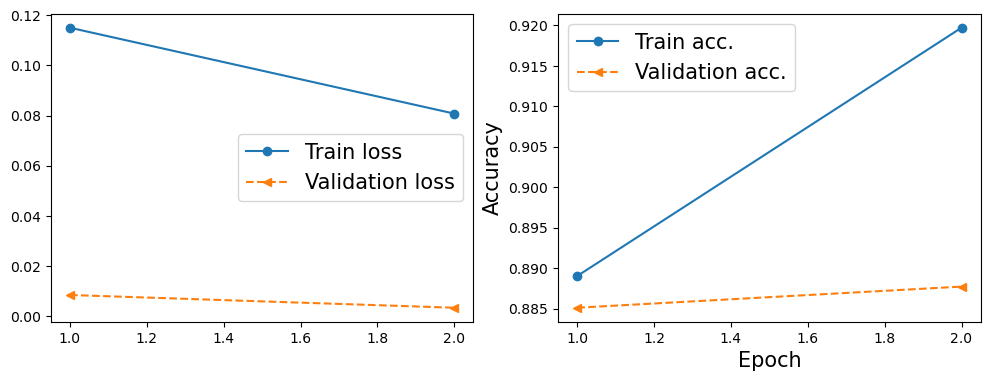

In [40]:
plot_learning_curves(hist)

### Evaluate the model with test dataset

Checking the results of the test dataset…



In [41]:
print("Checking the results of test dataset.")
accu_test, _ = evaluate(model, test_dataloader)
print("test accuracy {:8.3f}".format(accu_test))

Checking the results of test dataset.
test accuracy    0.878


In [42]:
# create confusion matrix
def plot_confusion_matrix(model, dataloader):
    model.eval()
    y_test = np.asarray([])
    y_predict = np.asarray([])

    with torch.no_grad():
        for idx, (data, label) in enumerate(dataloader):
            outputs = model(input_ids=data.input_ids, attention_mask=data.attention_mask)
            predicted_label = outputs.logits
                  
            y_test = np.concatenate((y_test, np.asarray(label.to(device='cpu', dtype=torch.long))), axis=None)
            y_predict = np.concatenate((y_predict, np.asarray((predicted_label.argmax(1).to(device='cpu', dtype=torch.long)))), axis=None)

    cm = confusion_matrix(y_test, y_predict)
    sns.heatmap(cm, annot=True, fmt = "d")
    print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

         0.0       0.94      0.81      0.87       108
         1.0       0.83      0.94      0.88       105

    accuracy                           0.88       213
   macro avg       0.88      0.88      0.88       213
weighted avg       0.88      0.88      0.88       213



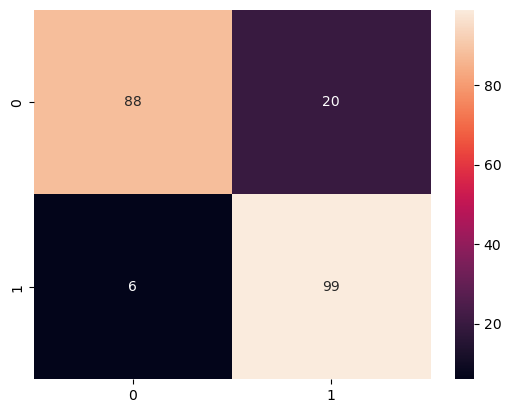

In [43]:
plot_confusion_matrix(model, test_dataloader)

In [44]:
def predict(text):
    with torch.no_grad():
        encoded_text = tokenizer(text)
        encoded_text.input_ids = torch.tensor(encoded_text.input_ids).to(device).unsqueeze(0)
        encoded_text.attention_mask = torch.tensor(encoded_text.attention_mask).to(device).unsqueeze(0)

        outputs = model(input_ids=encoded_text.input_ids, attention_mask=encoded_text.attention_mask)
        predicted_label = outputs.logits
        return predicted_label.argmax(1).item()

In [45]:
ex_text_str = 'The ePump Software shall define Fault ID 1 as follows:'

print("This is a %s" % predict(ex_text_str))

This is a 1


In [46]:
pred_text = "The IO Service shall select the XLR-PW DEV_INFO_DATA file if HPP_XLR_WIRING is grounded (logical 1) and bits AC_TYPE_BIT1 - AC_TYPE_BIT6 do not indicate a CFM engine configuration. NOTE: HPP_XLR_WIRING and bits AC_TYPE_BIT[1-6] are discrete inputs which are received on constant pins between hardware configurations. See 282100-ICD-x for more details."
predict(pred_text)

1

In [47]:
pred_text = "I shall like waffles"
predict(pred_text)

0

In [48]:
pred_text = "Bumblebe is red"
predict(pred_text)

1

In [49]:
pred_text = "Bumblebee is red"
predict(pred_text)

1

In [50]:
model_engine.save_16bit_model(f"./models/{model_name}/", f"{today}_{model_name}.pth")

[2024-05-10 07:53:11,818] [INFO] [logging.py:96:log_dist] [Rank 0] [Torch] Checkpoint global_step2596 is about to be saved!
[2024-05-10 07:53:11,818] [INFO] [engine.py:3596:save_16bit_model] Saving model weights to ./models/gemma_2b/2024-05-10_gemma_2b.pth, tag: global_step2596
[2024-05-10 07:53:11,818] [INFO] [torch_checkpoint_engine.py:21:save] [Torch] Saving ./models/gemma_2b/2024-05-10_gemma_2b.pth...
[2024-05-10 07:53:15,743] [INFO] [torch_checkpoint_engine.py:23:save] [Torch] Saved ./models/gemma_2b/2024-05-10_gemma_2b.pth.
[2024-05-10 07:53:15,744] [INFO] [torch_checkpoint_engine.py:33:commit] [Torch] Checkpoint global_step2596 is ready now!


True

In [51]:
loaded_state_dict = torch.load(f"/home/it/environments/Genety/models/{model_name}/{today}_{model_name}.pth", mmap=True)
loaded_state_dict

OrderedDict([('model.embed_tokens.weight',
              tensor([[ 5.3516e-01, -3.4668e-02,  9.5215e-02,  ...,  3.9307e-02,
                        2.6562e-01,  7.2266e-02],
                      [ 1.5137e-01, -1.7188e-01, -1.4160e-01,  ..., -2.4414e-02,
                        1.2493e-04, -3.3691e-02],
                      [ 1.1914e-01,  1.9165e-02, -3.1738e-02,  ..., -6.5613e-03,
                        3.4714e-04, -8.9111e-03],
                      ...,
                      [ 2.8711e-01, -1.1475e-02,  6.4453e-02,  ..., -5.7861e-02,
                        3.3447e-02, -4.0039e-02],
                      [ 3.4375e-01, -6.6895e-02,  8.5449e-02,  ..., -8.7891e-03,
                        8.0078e-02,  8.1787e-03],
                      [ 5.3906e-01, -3.4424e-02,  9.2285e-02,  ...,  3.7842e-02,
                        2.6562e-01,  7.1777e-02]], dtype=torch.float16)),
             ('model.layers.0.self_attn.q_proj.weight',
              tensor([[ 4.0436e-04, -1.0742e-02, -1.2207e-02,  .

In [59]:
model.load_state_dict(loaded_state_dict, assign=True)

<All keys matched successfully>

In [60]:
torch.save(model, f"./models/{model_name}/{today}_{model_name}.pt")

# Hyperparameter tunning with Ray Tune

In [33]:
os.environ['RAY_memory_monitor_refresh_ms'] = "0"

In [34]:
import time
from datetime import datetime, date

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import ray
import ray.train.torch

from ray import train, tune
from ray.train import RunConfig, ScalingConfig, Checkpoint
from ray.train.torch import TorchTrainer

from ray.tune.schedulers import ASHAScheduler

# DeepSpeed ZeRO-3 and Ray Train
import deepspeed
from deepspeed.accelerator import get_accelerator

In [35]:
from torch.utils.data import DataLoader

# function passed to the DataLoader to process a batch of data as indicated
tokenizer.pad_token = tokenizer.eos_token

def collate_batch(batch):
    # Get label and text
    y, x = list(zip(*batch))

    # Create list with indices from tokeniser
    encoded_x = tokenizer(x, padding=True, truncation=True)
    encoded_x.input_ids = torch.tensor(encoded_x.input_ids)
    encoded_x.attention_mask = torch.tensor(encoded_x.attention_mask)
    
    return encoded_x, torch.tensor(y, dtype=torch.long)

In [36]:
def train_func(model, optimizer, train_loader, max_norm, device):  
    model.train()
    
    total_acc, total_count = 0, 0
    log_interval = 5
    start_time = time.time()
    total_loss = 0

    for idx, (encoded_x, label) in enumerate(train_loader):           
        label = label.to(device)
        
        
        encoded_x.input_ids = encoded_x.input_ids.to(device)
        encoded_x.attention_mask = encoded_x.attention_mask.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(input_ids=encoded_x.input_ids, attention_mask=encoded_x.attention_mask)
        predicted_label = outputs.logits
        loss = criterion(predicted_label, label)
        
        # Deepspeed model engine, backward pass 
        model.backward(loss)
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        
        # Deepspeed model engine, optimizer step
        model.step()
        
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        total_loss += loss.item()
        
        # Deepspeed model engine, empty cache
        model.empty_partition_cache()
         
    return total_acc / total_count, total_loss / total_count
        

def eval_func(model, data_loader, device):
    model.eval()
    
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (encoded_x, label) in enumerate(data_loader):
            label = label.to(device)
            
            encoded_x.input_ids = encoded_x.input_ids.to(device)
            encoded_x.attention_mask = encoded_x.attention_mask.to(device)
            
            outputs = model(input_ids=encoded_x.input_ids, attention_mask=encoded_x.attention_mask)
            predicted_label = outputs.logits
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)

    return total_acc / total_count, loss.item() / total_count

In [37]:
def create_model():
    model = torch.hub.load(
        "huggingface/pytorch-transformers",
        "modelForSequenceClassification",
        "google/gemma-2b"
    )
    
    model.score = nn.Sequential(
        nn.Linear(in_features=2048, out_features=2048),
        nn.Dropout(),
        nn.Linear(in_features=2048, out_features=2),
    )
    model.config.pad_token_id = tokenizer.pad_token_id

    return model

In [38]:
import os
import tempfile

today = date.today().isoformat()
model_name = "llama3_8b"
checkpoint_path = f"./models/{model_name}"
num_class = 2

def train_search(config):
    print("Starting train_search")
    
    # print(device)
    # print(config)
    # config_params = config["params"]
    config_params = config
    # print(config_params)

    print(" Before create_model")
    model = create_model()
    print("Model after create_model")
    
    train_iter = iter(list(train_df.itertuples(index=False, name=None)))
    test_iter = iter(list(test_df.itertuples(index=False, name=None)))
    train_dataset = to_map_style_dataset(train_iter)
    test_dataset = to_map_style_dataset(test_iter)
    num_train = int(len(train_dataset) * 0.8)
    split_train_, split_valid_ = random_split(
        train_dataset, [num_train, len(train_dataset) - num_train]
    )

    train_dataloader = DataLoader(
        split_train_, batch_size=config_params["batch_size"], shuffle=True, collate_fn=collate_batch
    )
    valid_dataloader = DataLoader(
        split_valid_, batch_size=config_params["batch_size"], shuffle=True, collate_fn=collate_batch
    )
    test_dataloader = DataLoader(
        test_dataset, batch_size=config_params["batch_size"], shuffle=True, collate_fn=collate_batch
    )
    
    deepspeed_config = {
        "optimizer": {
            "type": "Adam",
            "params": {
                "lr": 0.01,
                "betas": [
                    0.8,
                    0.999
                ],
                "eps": 1e-8,
                "weight_decay": 3e-7,
            },
        },
        "scheduler": {
            "type": "WarmupLR",
            "params": {
                "warmup_min_lr": 0,
                "warmup_max_lr": 0.01,
                "warmup_num_steps": 1000,
            },
        },
        "train_batch_size": 16,
        # "train_micro_batch_size_per_gpu": "auto",
        # "gradient_accumulation_steps": "auto",
        "fp16": {"enabled": True},
        "zero_optimization": {
            "stage": 3,
            "offload_optimizer": {
                "device": "cpu",
            },
            "offload_param": {
                "device": "cpu",
            },
            "allgather_partitions": True,
            "allgather_bucket_size": 2e8,
            "reduce_scatter": True,
            "reduce_bucket_size": 2e8,
            "overlap_comm": True,
            "load_from_fp32_weights": True,
            "gather_16bit_weights_on_model_save": True,
            "contiguous_gradients": True,
            "stage3_prefetch_bucket_size": 0,
        },
        "gradient_accumulation_steps": 1,
        "train_batch_size": 16,
    }
    
    print("Before initializing deepspeed")
    
    
    # Initialize DeepSpeed Engine
    model, optimizer, _, lr_scheduler = deepspeed.initialize(
        model=model,
        model_parameters=model.parameters(),
        config=deepspeed_config,
    )
    device = get_accelerator().device_name(model.local_rank)
    print(f"deepspeed accelerator device: {device}")
    
    best_accu_val = 0.85
    for epoch in range(1, config_params["epochs"] + 1):
        epoch_start_time = time.time()
        accu_train, loss_train = train_func(model, optimizer, train_dataloader, config_params["max_norm"], device)
        accu_val, loss_val = eval_func(model, valid_dataloader, device)
        
            
        # Report checkpoint and metrics to Ray Train
        # ==============================================================
        with tempfile.TemporaryDirectory() as tmpdir:
            # Each worker saves its own checkpoint shard
            if accu_val > best_accu_val:
                model.save_checkpoint(tmpdir)
                checkpoint = Checkpoint.from_directory(tmpdir)
                best_accu_val = accu_val

            # Ensure all workers finished saving their checkpoint shard
            torch.distributed.barrier()

            # Report checkpoint shards from each worker in parallel
            ray.train.report(
                metrics={
                    # "loss_train": loss_train,
                    # "loss_val": loss_val,
                    "accuracy_train": accu_train,
                    "accuracy_val": accu_val,
                }, checkpoint=checkpoint
            )
        # ==============================================================
        
        get_accelerator().empty_cache()

In [39]:
import gc

model = None

gc.collect()
torch.cuda.empty_cache()
get_accelerator().empty_cache()

In [40]:
(free_memory, global_memory) = torch.cuda.mem_get_info()
print(f"Free(GB): {free_memory/1024/1024/1024}, Global(GB): {global_memory/1024/1024/1024}, Free(%): {free_memory/global_memory}")

Free(GB): 23.25555419921875, Global(GB): 23.64971923828125, Free(%): 0.9833332042934161


In [41]:
import numpy as np
from hyperopt import hp
from ray.tune.search.hyperopt import HyperOptSearch

exp_name = model_name

space = {
    "lr": hp.loguniform("lr", -3, 1),
    # "momentum": hp.uniform("momentum", 0.1, 0.9),
    "epochs": hp.choice("epochs", [3]),
    "batch_size": hp.choice("batch_size", [16]),
    # "step_size": hp.randint("step_size", 1, 10),
    # "lr_gamma": hp.uniform("lr_gamma", 0.1, 0.9),
    "max_norm": hp.uniform("max_norm", 0.1, 0.9),
}

hyperopt_search = HyperOptSearch(space, metric="accuracy_val", mode="max")

# Uncomment this to enable distributed execution
# `ray.init(address="auto")`

tuner = tune.Tuner(
    tune.with_resources(train_search, resources={"cpu":1, "gpu":1}),
    tune_config=tune.TuneConfig(
        num_samples=1,
        scheduler=ASHAScheduler(metric="accuracy_val", mode="max"), # Early stopping
        search_alg=hyperopt_search, # Hyperopt library for Hyper-parameter Optimization
    ),
    run_config=train.RunConfig(
        name=exp_name,
        checkpoint_config=train.CheckpointConfig(
            checkpoint_score_attribute="accuracy_val",
            num_to_keep=2,
            # checkpoint_at_end=True
        ),
    ),
)
results = tuner.fit()

(raylet) Warning: The actor ImplicitFunc is very large (11 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


(pid=42436) /home/it/anaconda3/envs/genety/lib/python3.11/site-packages/torchtext/data/__init__.py:4: UserWarning: 
(pid=42436) /!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
(pid=42436) Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
(pid=42436)   warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


(pid=42436) [2024-05-14 12:47:22,708] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)
(pid=42436)  [WARNING]  async_io requires the dev libaio .so object and headers but these were not found.
(pid=42436)  [WARNING]  If libaio is already installed (perhaps from source), try setting the CFLAGS and LDFLAGS environment variables to where it can be found.
(pid=42436)  [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH
(pid=42436)  [WARNING]  sparse_attn requires a torch version >= 1.5 and < 2.0 but detected 2.3
(pid=42436)  [WARNING]  using untested triton version (2.3.0), only 1.0.0 is known to be compatible
(train_search pid=42436) Starting train_search
(train_search pid=42436)  Before create_model


(train_search pid=42436) Using cache found in /home/it/.cache/torch/hub/huggingface_pytorch-transformers_main
(train_search pid=42436) Gemma's activation function should be approximate GeLU and not exact GeLU.
(train_search pid=42436) Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.
Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.12s/it]
(train_search pid=42436) Some weights of GemmaForSequenceClassification were not initialized from the model checkpoint at google/gemma-2b and are newly initialized: ['score.weight']
(train_search pid=42436) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(train_search pid=42436) Model after create_model
(train_search pid=42436) Before initializing deepspeed
(train_search pid=42436) [2024-05-14 12:47:28,692] [INFO] [logging.py:96:log_dist] [Rank -1] DeepSpeed info: version=0.14.2, git-hash=unknown, git-branch=unknown
(train_search pid=42436) [2024-05-14 12:47:28,692] [INFO] [comm.py:637:init_distributed] cdb=None
(train_search pid=42436) [2024-05-14 12:47:28,692] [INFO] [comm.py:652:init_distributed] Not using the DeepSpeed or dist launchers, attempting to detect MPI environment...
(train_search pid=42436) [2024-05-14 12:47:28,947] [INFO] [comm.py:702:mpi_discovery] Discovered MPI settings of world_rank=0, local_rank=0, world_size=1, master_addr=10.1.1.204, master_port=29500
(train_search pid=42436) [2024-05-14 12:47:28,947] [INFO] [comm.py:668:init_distributed] Initializing TorchBackend in DeepSpeed with backend nccl
(train_search pid=42436) [2024-05-14 12:47:31,477] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed Flops Profiler Ena

(train_search pid=42436) Using /home/it/.cache/torch_extensions/py311_cu121 as PyTorch extensions root...
(train_search pid=42436) Detected CUDA files, patching ldflags
(train_search pid=42436) Emitting ninja build file /home/it/.cache/torch_extensions/py311_cu121/cpu_adam/build.ninja...
(train_search pid=42436) /home/it/anaconda3/envs/genety/lib/python3.11/site-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
(train_search pid=42436) If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
(train_search pid=42436)   warnings.warn(
(train_search pid=42436) Building extension module cpu_adam...
(train_search pid=42436) Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
(train_search pid=42436) Loading extension module cpu_adam...


(train_search pid=42436) Installed CUDA version 12.3 does not match the version torch was compiled with 12.1 but since the APIs are compatible, accepting this combination
(train_search pid=42436) ninja: no work to do.
(train_search pid=42436) Time to load cpu_adam op: 2.1970419883728027 seconds
(train_search pid=42436) [2024-05-14 12:47:35,100] [INFO] [logging.py:96:log_dist] [Rank 0] Using DeepSpeed Optimizer param name adam as basic optimizer
(train_search pid=42436) [2024-05-14 12:47:35,100] [INFO] [logging.py:96:log_dist] [Rank 0] Removing param_group that has no 'params' in the basic Optimizer
(train_search pid=42436) [2024-05-14 12:47:35,101] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed Basic Optimizer = DeepSpeedCPUAdam
(train_search pid=42436) [2024-05-14 12:47:35,101] [INFO] [utils.py:56:is_zero_supported_optimizer] Checking ZeRO support for optimizer=DeepSpeedCPUAdam type=<class 'deepspeed.ops.adam.cpu_adam.DeepSpeedCPUAdam'>
(train_search pid=42436) [2024-05-14 12:47:3

RuntimeError: Caught unexpected exception: Task was killed due to the node running low on memory.
Memory on the node (IP: 10.1.1.204, ID: 997e9efaf47a89addcbbe9a285e738837b0e0746aabd8239c15caaca) where the task (actor ID: e950d00f0e30c610b3bcae3601000000, name=ImplicitFunc.__init__, pid=42436, memory used=27.71GB) was running was 30.03GB / 30.56GB (0.982575), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 2ac0572626f22e87377aeaa11a7f691ce880f1c46be0fd7cfd872af0) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 10.1.1.204`. To see the logs of the worker, use `ray logs worker-2ac0572626f22e87377aeaa11a7f691ce880f1c46be0fd7cfd872af0*out -ip 10.1.1.204. Top 10 memory users:
PID	MEM(GB)	COMMAND
42436	27.71	ray::ImplicitFunc.train
40567	0.88	/home/it/anaconda3/envs/genety/bin/python -m ipykernel_launcher -f /home/it/.local/share/jupyter/run...
40635	0.11	/home/it/anaconda3/envs/genety/lib/python3.11/site-packages/ray/core/src/ray/gcs/gcs_server --log_di...
40708	0.05	/home/it/anaconda3/envs/genety/bin/python /home/it/anaconda3/envs/genety/lib/python3.11/site-package...
40841	0.03	/home/it/anaconda3/envs/genety/bin/python -u /home/it/anaconda3/envs/genety/lib/python3.11/site-pack...
1884	0.03	/usr/bin/python3 /usr/bin/jupyter-notebook --ip 0.0.0.0 --no-browser
40786	0.02	/home/it/anaconda3/envs/genety/lib/python3.11/site-packages/ray/core/src/ray/raylet/raylet --raylet_...
40843	0.01	/home/it/anaconda3/envs/genety/bin/python -u /home/it/anaconda3/envs/genety/lib/python3.11/site-pack...
40707	0.01	/home/it/anaconda3/envs/genety/bin/python -u /home/it/anaconda3/envs/genety/lib/python3.11/site-pack...
40839	0.00	/home/it/anaconda3/envs/genety/bin/python -u /home/it/anaconda3/envs/genety/lib/python3.11/site-pack...
Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. Set max_restarts and max_task_retries to enable retry when the task crashes due to OOM. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.

In [ ]:
dfs = {result.path: result.metrics_dataframe for result in results}
[d["accuracy_val"].plot() for d in dfs.values()]

(raylet) [2024-05-14 12:47:58,150 E 40786 40786] (raylet) node_manager.cc:2963: 2 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 997e9efaf47a89addcbbe9a285e738837b0e0746aabd8239c15caaca, IP: 10.1.1.204) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 10.1.1.204`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
